## CPA on firmware Implementation of AES

*By now, you'll have used a DPA attack to break AES. While this method has its place in side channel attacks, it often requires a large number of traces to break AES and can suffer from additional issues like ghost peaks.*

*One should notice that there is a very linear relationship between the hamming weight of the SBox output and the power consumption at that point. Instead of checking average power consumption over many traces to see if a guessed subkey is correct (via maximum SDA for [the one_list & zero_list] (which have trace_array inside them) as we done before in the DPA attack ), we can instead check if our guessed subkey also has this linear relationship with the device's power consumption across a set of traces. Like with DPA, we'll need to repeat this measurement at each point in time along the power trace.*

*To get an objective measurement of how linear this relationship is, we'll be developing some code to calculate the Pearson correlation coefficient.*

**GOALS:**
* Developing an algorithm based on a mathematical description
* Verify that correlation can be used to break a single byte of AES
* Extend the single byte attack to the rest of the key

#### AES Trace Capture
Our first step will be to send some plaintext to the target device and observe its power consumption during the encryption. The capture loop will be the same as in the DPA attack. This time, however, we'll only need 75 traces to recover the key, a major improvement over the last attack!

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'AVRCRYPTOLIB'
SS_VER = 'SS_VER_1_1'

In [2]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWLITEXMEGA with CRYPTO_TARGET=AVRCRYPTOLIB
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes-independant.s aes_enc.s aes_keyschedule.s aes_sbox.s aes128_enc.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes-independant.d aes_enc.d aes_keyschedule.d aes_sbox.d aes128_enc.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes-independant.i aes_enc.i aes_keyschedule.i aes_sbox.i aes128_enc.i
.
Welcome

In [4]:
fw_path = "../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3761 bytes


In [13]:
scope.clock.adc_src = 'clkgen_x1'
scope.adc.samples = 5000

In [14]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 75
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next()
    
trace_array = np.array(trace_array)

Capturing traces:   0%|          | 0/75 [00:00<?, ?it/s]

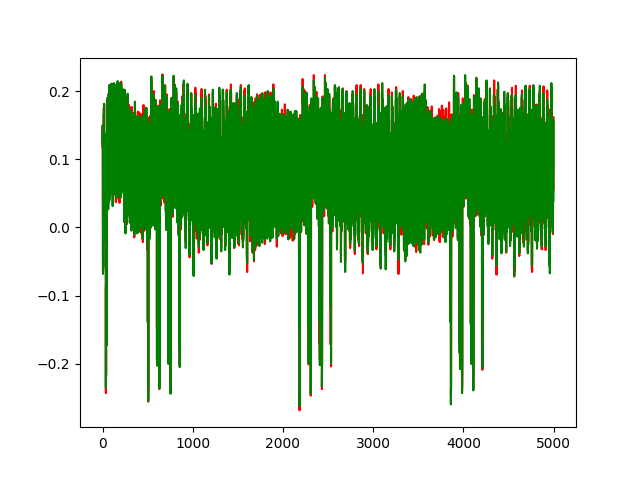

In [15]:
%matplotlib ipympl
import matplotlib.pylab as plt

plt.plot(trace_array[0], color='red')
plt.plot(trace_array[1], color='green')
plt.show()

### AES Model and Hamming Weight

In [17]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [18]:
HW = [bin(num).count("1") for num in range(256)]

In [19]:
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

✔️ OK to continue!


Pearson Correlation Coefficient

As we discussed earlier, we'll be testing how good our guess is using a measurement called the Pearson correlation coefficient, which measures the linear correlation between two datasets. 

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

As you can see, the calulation is actually broken down pretty nicely into some smaller chunks that we can implement with some simple functions. While we could use a library to calculate all this stuff for us, being able to implement a mathematical algorithm in code is a useful skill to develop. 

To start, build the following functions:

1. `mean(X)` to calculate the mean of a dataset (the mean being `X_bar` that will be used elsewhere).
1. `std_dev(X, X_bar)` to calculate the standard deviation of a dataset. We'll need to reuse the mean for the covariance, so it makes more sense to calculate it once and pass it in to each function
1. `cov(X, X_bar, Y, Y_bar)` to calculate the covariance of two datasets. Again, we can just pass in the means we calculate for std_dev here.
#### Note that division with N is ommited when calculating both the standard deviation and the covarience, but essentialy the pearson factor is identical even if we omit the division

In [20]:
import numpy as np
def mean(X):
    return (np.average(X, axis=0))
def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((Y-Y_bar)*(X-X_bar), axis=0)

In [21]:
X_bar = mean(trace_array)
print(np.shape(trace_array))
print(np.shape(X_bar))
print(np.shape(trace_array-X_bar))
s = std_dev(trace_array, X_bar)
print(np.shape(s))

(75, 5000)
(5000,)
(75, 5000)
(5000,)


In [22]:
print(trace_array)

[[0.11816406 0.14453125 0.15039062 ... 0.16210938 0.05566406 0.05566406]
 [0.12304688 0.1484375  0.13769531 ... 0.15722656 0.04199219 0.0390625 ]
 [0.10839844 0.14160156 0.14648438 ... 0.15820312 0.03515625 0.03613281]
 ...
 [0.12304688 0.14550781 0.14746094 ... 0.15429688 0.02636719 0.03125   ]
 [0.12109375 0.140625   0.14453125 ... 0.16015625 0.03125    0.04394531]
 [0.11523438 0.14257812 0.15429688 ... 0.16113281 0.04199219 0.03027344]]


You should have something like the following:
```python
[
    [point_0, point_1, point_2, ...], # trace 0
    [point_0, point_1, point_2, ...], # trace 1
    [point_0, point_1, point_2, ...], # trace 2
    ...
]
```

where the rows of the array are the different traces we captured and the columns of the array are the different points in those traces. The columns here will be one of the two datasets for our correlation equation. The other dataset will be the hamming weight of the SBox output, for a given *key guess* `key` of the byte we are looking at:

```python
[
      [HW[aes_internal(plaintext0[0], key[0])], # trace 0
      [HW[aes_internal(plaintext1[0], key[0])], # trace 1
      [HW[aes_internal(plaintext2[0], key[0])], # trace 2
      ...
]
```

which we'll shorten to:

```python
[
      [hw], # trace 1
      [hw], # trace 2
      [hw], # trace 3
      ...
]
```

Like with the DPA attack, we don't know where the encryption is occurring, meaning we have to repeat the correlation calculation for each column in the trace array, with the largest correlation being our best guess for where the SBox output is happening. We obviously also don't know the key (that's the thing we're trying to find!), so we'll also need to repeat the best correlation calculation for each possible value of `key[0]` (0 to 255). The key with the highest absolute correlation is our best guess for the value of the key byte.

The correlation attack is basically to calculate this:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

Where:

* $X$ is a power trace sample point
* $Y$ is an internal state guess



The only caveat being that we need to make sure that the columns and rows of our arrays are the right way around (i.e. make sure your hamming weight array has 1 column and 50 rows and not the other way around). If you find it easier to construct and array one way and not the other, you can use the `.transpose()` method to swap the rows and columns.

### Finding Largest Correlation

Once you've got all your correlations for a particular key guess, you want to find the largest absolute correlation. We're taking the absolute value of the correlation here since we only care that the relation between hamming weight and the power trace is linear, not that the slope is positive or negative. `max(abs(correlations))` will do that for you.

### Enumerating Guesses

Perform this for every possible value of the key byte (aka 0 to 255) and the one with the largest correlation is your best guess for the key. It's up to you how you want to extract this information from your loop, but one way of doing it is to stick the best guess for each of your key guesses in an array. Once you've gone through all the key guesses, you can extract the best guess with `np.argmax(maxcpa)` and the correlation of that guess with `max(maxcpa)`.

### Equation to Python

We can take the earlier equation and plug in some of our Python variable names to give you a good starting point. We are using:

* $r$ = `cpaoutput`
* $X$ = `t` or `trace_array` (the average of it called `t_bar`).
* $Y$ = `hws` (the mean of it called `hws_bar`).

Our equation now looks something like this:

$$cpaoutput = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

In [23]:
maxcpa = [0] * 256
t_bar = mean(trace_array)
o_t = std_dev(trace_array, t_bar)

guessed_byte = 0

for kguess in trange(0, 256, desc='Attacking first byte'):
    hws = np.array([[HW[aes_internal(text[guessed_byte], kguess)] for text in textin_array]]).transpose()
    hws_bar = mean(hws)
    o_hw = std_dev(hws,hws_bar)
    correlation = cov(X=trace_array, X_bar=t_bar, Y=hws, Y_bar=hws_bar)
    cpaoutput = correlation / (o_hw * o_t)
    maxcpa[kguess] = max(abs(cpaoutput))

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)

print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

print(np.shape(maxcpa))
print(np.shape(hws))
print(np.shape(cpaoutput))
# print(np.shape(correlation))
# print(np.shape(o_hw*o_t))
# print(np.shape(trace_array-t_bar))
# print(np.shape(hws-hws_bar))
# print(np.shape(np.sum((trace_array-t_bar)*(hws-hws_bar), axis=0)))

Attacking first byte:   0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0x2b
Correlation:  0.8325395300188692
(256,)
(75, 1)
(5000,)


In [24]:
assert guess == 0x2b
print("✔️ OK to continue!")

✔️ OK to continue!


To break the rest of the key, simply repeat the attack for the rest of the bytes of the key.

In [25]:
guess = [0] * 16
guess_corr = [0] * 16
t_bar = mean(trace_array)
o_t = std_dev(trace_array, t_bar)

for bnum in trange(0, 16, desc='Attacking full key'):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        hws = np.array([[HW[aes_internal(text[bnum], kguess)] for text in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hw = std_dev(hws,hws_bar)
        correlation = cov(X=trace_array, X_bar=t_bar, Y=hws, Y_bar=hws_bar)
        cpaoutput = correlation / (o_hw * o_t)
        maxcpa[kguess] = max(abs(cpaoutput))

    guess[bnum] = np.argmax(maxcpa)
    guess_corr[bnum] = max(maxcpa)

print('Best Key Guess: ', end='')
for b in guess:
    print('{:02X} '.format(b), end='')
print('\n', guess_corr)
# print(np.shape(cpaoutput))
# print(np.shape(correlation))
# print(np.shape(o_hw*o_t))
# print(np.shape(trace_array-t_bar))
# print(np.shape(hws-hws_bar))
# print(np.shape(np.sum((trace_array-t_bar)*(hws-hws_bar), axis=0)))

Attacking full key:   0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess: 2B 7E 15 16 28 AE D2 A6 AB F7 15 88 09 CF 4F 3C 
 [0.8325395300188692, 0.7938819219242577, 0.8267209010736187, 0.7868367948097585, 0.8503106111515817, 0.8476986151870491, 0.7883058451605146, 0.8132859938927154, 0.7460383131616732, 0.7952520099971143, 0.860315847277319, 0.8071286633602708, 0.7249156136457574, 0.7766963176095703, 0.7348149013001152, 0.7772288489211641]


In [26]:
for bnum in range(16):
    assert guess[bnum] == key[bnum], \
    "Byte {} failed, expected {:02X} got {:02X}".format(bnum, key[bnum], guess[bnum])
print("✔️ OK to continue!")

✔️ OK to continue!


Well, There's actually a lot of room to expand on this attack:

1. Currently, the loop needs to go through all the traces before it can return a correlation. This isn't too bad for a short attack, for a much longer one (think 10k+ traces) we won't get any feedback from the attack until it's finished. Also, if we didn't capture enough traces for the attack, the entire analysis calculation needs to be repeated! Instead of using the original correlation equation, we can instead use an equivalent "online" version that can be easily updated with more traces: $$r_{i,j} = \frac{D\sum_{d=1}^{D}h_{d,i}t_{d,j}-\sum_{d=1}^{D}h_{d,i}\sum_{d=1}^{D}t_{d,j}}{\sqrt{((\sum_{d=1}^Dh_{d,i})^2-D\sum_{d=1}^Dh_{d,i}^2)-((\sum_{d=1}^Dt_{d,j})^2-D\sum_{d=1}^Dh_{d,j}^2)}}$$
where

| **Equation** | **Python Variable** | **Value**  | 
|--------------|---------------------|------------|
|  d           |       tnum          | trace number |
|  i           |       kguess        | subkey guess |
| j | j index trace point | sample point in trace |
| h | hypint | guess for power consumption | 
| t | traces | traces | 

2. There's a lot more we can learn from the attack other than the key. For example, we could plot how far away the correct key guess is from the top spot (called the partial guessing entropy or PGE) vs. how many traces we used, giving us a better idea of how many traces we needed to actually recover the correct key. We also might want to plot how correlation for a given key guess changes over time.

This "online" correlation equation is the one that the subject of the next tutorial, ChipWhisperer Analyzer, actually uses. It also provides functions and methods for gathering and plotting some interesting statistics.

In [35]:
from tqdm.notebook import trange

ktp = cw.ktp.Basic()

proj = cw.create_project("cpa_traces", overwrite=True)

N = 1000
for i in trange(N, desc='Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    if not trace:
        continue
    
    proj.traces.append(trace)
proj.save()

Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
print(proj.waves[0])

[0.12109375 0.13769531 0.14941406 ... 0.1640625  0.04980469 0.04980469]


In [38]:
import chipwhisperer.analyzer as cwa
#pick right leakage model for your attack
leak_model = cwa.leakage_models.sbox_output
attack = cwa.cpa(proj, leak_model)
results = attack.run(cwa.get_jupyter_callback(attack), update_interval=100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2B0.831,7E0.801,150.823,160.782,280.788,AE0.793,D20.790,A60.761,AB0.806,F70.819,150.900,880.826,090.833,CF0.793,4F0.779,3C0.844
1,2A0.591,7F0.647,140.636,170.591,290.582,AF0.532,D30.635,A70.565,AA0.582,F60.568,140.605,890.576,080.599,CE0.571,4E0.577,3D0.597
2,770.326,DE0.349,EF0.296,E20.290,4F0.304,AB0.302,ED0.289,F20.310,B10.294,B00.296,320.296,4F0.280,370.288,D90.299,E50.298,A00.292
3,7F0.277,8B0.313,200.269,7C0.275,BC0.286,760.299,F10.278,F30.297,370.292,750.277,E60.293,B30.270,200.278,8F0.274,CD0.273,390.286
4,030.276,AF0.300,080.266,C80.274,410.281,3E0.292,E60.269,990.277,7D0.283,E10.266,240.283,420.269,830.274,3D0.273,B80.273,210.282


KeyboardInterrupt: 

In [36]:
import chipwhisperer.common.api.lascar as cw_lascar
from lascar import *
cw_container = cw_lascar.CWContainer(proj, proj.textins)
cpa_engines = [CpaEngine("cpa_%02d" % i, cw_lascar.sbox_HW_gen(i), range(256)) for i in range(16)]
session = Session(cw_container, engines=cpa_engines).run(batch_size=50)

2021-12-16 18:10:44,105 - lascar.session - INFO - Session Session: 1000 traces, 18 engines, batch_size=50, leakage_shape=(5000,)
INFO:lascar.session:Session Session: 1000 traces, 18 engines, batch_size=50, leakage_shape=(5000,)
Session |  0%||0 trc/1000 | (18 engines, batch_size=50, leakage_shape=(5000,)) |ETA:  --:--:--

Debug:
50


Session |100%||1000 trc/1000 | (18 engines, batch_size=50, leakage_shape=(5000,)) |Time:  0:00:16


In [37]:
disp = cw_lascar.LascarDisplay(cpa_engines, list(proj.keys[0]))
disp.show_pge()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2B0.807,7E0.789,150.793,160.796,280.795,AE0.774,D20.790,A60.761,AB0.793,F70.779,150.906,880.819,090.801,CF0.793,4F0.800,3C0.835
1,2A0.571,7F0.631,140.619,170.580,290.615,AF0.585,D30.590,A70.555,AA0.591,F60.594,140.594,890.574,080.606,CE0.559,4E0.575,3D0.580
2,770.242,8B0.233,DF0.220,840.229,BC0.218,5B0.231,EE0.228,530.253,5E0.217,020.204,2B0.214,7D0.241,BD0.224,560.220,3A0.232,A00.232
3,B70.240,D30.211,590.215,7A0.219,E00.216,B30.220,ED0.227,A90.224,940.188,740.197,C50.198,420.225,FC0.208,D90.219,BA0.210,840.210
4,DE0.226,420.205,E00.214,980.217,DA0.213,450.212,9B0.213,500.216,220.187,4A0.194,2A0.193,B10.206,450.202,3A0.217,F70.209,090.207
5,360.222,680.204,290.212,6F0.213,DD0.213,850.201,9F0.212,990.213,290.183,7E0.193,600.191,620.205,280.198,880.206,9C0.196,D30.203
6,500.197,400.203,1E0.211,C20.210,860.207,8E0.199,200.205,8E0.206,A00.181,830.189,F20.188,4C0.201,1A0.197,820.203,C20.189,690.202
7,840.194,730.200,C00.205,E30.195,390.194,000.196,A90.204,3F0.201,1F0.181,A50.186,C10.186,B30.195,F90.195,050.193,7A0.188,210.201
8,100.192,110.198,970.203,E40.194,4F0.188,900.195,180.202,CB0.200,0C0.181,B00.186,240.185,5E0.195,8B0.194,390.192,CD0.188,F60.197
9,470.186,470.197,200.202,0D0.190,270.187,770.194,540.199,CD0.199,DE0.179,B80.184,850.185,5C0.194,370.194,F00.191,260.188,CE0.191
